## Practical 1: word2vec
<p>Oxford CS - Deep NLP 2017<br>
https://www.cs.ox.ac.uk/teaching/courses/2016-2017/dl/</p>
<p>[Yannis Assael, Brendan Shillingford, Chris Dyer]</p>

- Modify so that embeddings generated only from training set
- Add all the other changes
- Please finish and don't drop

This practical is presented as an IPython Notebook, with the code written for recent versions of **Python 3**. The code in this practical will not work with Python 2 unless you modify it. If you are using your own Python installation, ensure you have a setup identical to that described in the installation shell script (which is intended for use with the department lab machines). We will be unable to support installation on personal machines due to time constraints, so please use the lab machines and the setup script if you are unfamiliar with how to install Anaconda.

To execute a notebook cell, press `shift-enter`. The return value of the last command will be displayed, if it is not `None`.

Potentially useful library documentation, references, and resources:

* IPython notebooks: <https://ipython.org/ipython-doc/3/notebook/notebook.html#introduction>
* Numpy numerical array library: <https://docs.scipy.org/doc/>
* Gensim's word2vec: <https://radimrehurek.com/gensim/models/word2vec.html>
* Bokeh interactive plots: <http://bokeh.pydata.org/en/latest/> (we provide plotting code here, but click the thumbnails for more examples to copy-paste)
* scikit-learn ML library (aka `sklearn`): <http://scikit-learn.org/stable/documentation.html>
* nltk NLP toolkit: <http://www.nltk.org/>
* tutorial for processing xml in python using `lxml`: <http://lxml.de/tutorial.html> (we did this for you below, but in case you need it in the future)

In [87]:
import numpy as np
import os
import math
import tensorflow as tf
from random import shuffle
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
% matplotlib inline

### Part 0: Download the TED dataset

In [88]:
import urllib.request
import zipfile
import lxml.etree


In [89]:
# Download the dataset if it's not already there: this may take a minute as it is 75MB
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip",
                               filename="ted_en-20160408.zip")

In [90]:
# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
input_text = doc.xpath('//content/text()')
tags = doc.xpath('//keywords/text()')


### Part 1: Preprocessing

In this part, we attempt to clean up the raw subtitles a bit, so that we get only sentences. The following substring shows examples of what we're trying to get rid of. Since it's hard to define precisely what we want to get rid of, we'll just use some simple heuristics.

Let's start by removing all parenthesized strings using a regex:

In [91]:
input_text_noparens = [re.sub(r'\([^)]*\)', '', text) 
                       for text in input_text]

In [92]:
texts = [re.sub(r"[^a-z0-9]+", " ", text.lower()) 
         for text in input_text_noparens]

In [93]:
from gensim.models import Word2Vec

In [94]:
tokenized = [text.split(" ") for text in texts]

In [95]:
shuffle = np.random.permutation(np.arange(len(tokenized)))

In [96]:
# shuffled_texts  = np.array(tokenized)[shuffle]

In [97]:
shuffled_texts = []
for i in shuffle:
    shuffled_texts.append(tokenized[i])

In [98]:
# inds = [0,-500,-250,None]
# train,val,test = [shuffled_texts[ind:inds[i+1]] for i,ind in enumerate(inds[:-1])]

In [99]:
train = shuffled_texts[:-500]
val = shuffled_texts[-500:-250]
test = shuffled_texts[-250:]

In [100]:
len(train),len(val),len(test)

(1585, 250, 250)

In [101]:
model_ted = Word2Vec(train,min_count=10,size=50)

In [102]:
#Pre-process to convert each document into a vector that is an average of its word vectors 
# - bag of means

In [103]:
def get_embedding(word):
    try:
        return model_ted[word]
    except KeyError:
        return np.zeros(50,dtype=np.float32)

def get_embeddings(text):
    return [get_embedding(word) for word in text]

In [104]:
bom_train,bom_val,bom_test\
= [
    np.array([np.mean(get_embeddings(text),axis=0) for text in data])
  for data in [train,val,test]
  ]

In [105]:
bom_train.shape

(1585, 50)

Labels

Each document should be labeled with label from the set: {Too, oEo, ooD, TEo, ToD, oED, TED, ooo}. You are called to generate labels from the <keywords> tag by checking the existence of one of the following tags: {Technology, Entertainment, Design}.

- None of the keywords → ooo
- “Technology” → Too
- “Entertainment” → oEo
- “Design” → ooD
- “Technology” and “Entertainment” → TEo
- “Technology” and “Design” → ToD
- “Entertainment” and “Design” → oED
- “Technology” and “Entertainment” and “Design” → TED

In [106]:
import itertools

def make_label(comb):
    return ''.join([let if num else 'o' for (let,num) in zip('TED',comb)])

all_labels = [make_label(comb) for comb in itertools.product(*[[0,1]]*3)]

label_dict = dict(zip(all_labels ,range(8)))


In [107]:
from sklearn.preprocessing import OneHotEncoder

tags = [tags_i.lower() for tags_i in tags]
labels = [make_label([tags_i.find(tag) >-1 for tag in ['technology','entertainment','design']]) 
          for tags_i in tags]

num_labels = np.array(list(map(label_dict.get,labels)))

enc = OneHotEncoder()
onehot_labels = enc.fit_transform(np.reshape(num_labels,(-1,1))).toarray()

shuffled_labels = onehot_labels[shuffle,:]

# y_train,y_val,y_test = [shuffled_labels[ind:inds[i+1],:] 
#                         for i,ind in enumerate(inds[:-1])]

y_train = shuffled_labels[:-500]
y_val = shuffled_labels[-500:-250]
y_test = shuffled_labels[-250:]

We can see that most of the documents seem to belong to class 0. Looking for these tags might not be the best way to go about this task. The reason is that documents might have similar but not identical keywords. A better strategy might be to use word vectors for technology, entertainment and design and to find tags which are close.

In [108]:
class TextClassifier():

    def __init__(self,  
                embed_dim,
                hid_dims,
                num_classes,
                nonlin=tf.tanh,
                optimizer=tf.train.AdamOptimizer(5e-4)):
        self.embed_dim = embed_dim
        self.hid_dims = hid_dims
        self.num_classes = num_classes
        self.nonlin = nonlin
        self.optimizer = optimizer
        
    def build_graph(self):
        if 'sess' in globals() and sess:
            sess.close()
        tf.reset_default_graph()
        is_train = tf.placeholder(tf.bool)
        x = tf.placeholder(tf.float32, [None,self.embed_dim])
        y = tf.placeholder(tf.int32,[None,self.num_classes])
        
        dims = [self.embed_dim]+self.hid_dims+[self.num_classes]
        
        h = x
        for i,dim in enumerate(dims[1:]):
            W = tf.get_variable("W%i"%i, shape=[dims[i],dim])
            b = tf.get_variable("b%i"%i, shape=[dim])
            if(i < len(dims)-2):
                h = self.nonlin(tf.nn.xw_plus_b(h,W,b))
                
        preds = tf.nn.xw_plus_b(h,W,b)
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(preds, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=preds))

        train_step = self.optimizer.minimize(loss)
        
        self.x = x
        self.y = y
        self.loss = loss
        self.preds = preds
        self.train_step = train_step
        self.is_train = is_train
        self.accuracy = accuracy
    
    def test(self,data):
        x_test,y_test = data
        with tf.Session() as sess:
            saver = tf.train.Saver()
            saver.restore(sess,'./')
            feed = {self.is_train: False,
                    self.x: x_test,
                    self.y: y_test}
            acc = sess.run([self.accuracy], feed_dict=feed)
        return acc
    
    def get_preds(self,data):
        x_test,y_test = data
        with tf.Session() as sess:
            saver = tf.train.Saver()
            saver.restore(sess,'./')
            feed = {self.is_train: False,
                    self.x: x_test,
                    self.y: y_test}
            preds = sess.run([self.preds], feed_dict=feed)
        return np.argmax(preds[0],axis=1)
        
    def train(self,
                    data,
                    verbose=False,
                    batch_size = 50,
                    num_epochs = 100, 
                    skip_step=10):

        (x_train,y_train),(x_test,y_test) = [data['train'],data['test']]

        with tf.Session() as sess:
            
            sess.run(tf.global_variables_initializer())

            self.tr_accs, self.te_accs = [], []
            self.tr_losses, self.te_losses = [], []

            train_size = x_train.shape[0]

            for epoch in range(num_epochs):
                shuffle = np.random.permutation(np.arange(train_size))
                x_train = x_train[shuffle,:]
                y_train = y_train[shuffle,:]

                accuracy = 0
                losses = []

                for i in range(math.ceil(train_size/batch_size)):
                    ix = slice(i*50,(i+1)*50)
                    feed = {self.is_train: True,
                        self.x: x_train[ix,:],
                        self.y: y_train[ix,:]}

                    acc,_,loss = sess.run([self.accuracy,
                                          self.train_step,
                                          self.loss], 
                                          feed_dict=feed)

                    actual_batch_size = x_train[ix,:].shape[0]
                    losses.append(loss*actual_batch_size)
                    accuracy += acc*actual_batch_size

                feed = {self.is_train: False,
                        self.x: x_test,
                        self.y: y_test}

                val_acc,val_loss = sess.run([self.accuracy,self.loss], feed_dict=feed)

                total_tr_acc = accuracy/x_train.shape[0]
                total_tr_loss = np.sum(losses)/x_train.shape[0]
                if(verbose):
                    print("Epoch {2}, Overall training loss = {0:.3g} and accuracy of {1:.3g}"\
                      .format(total_tr_loss,total_tr_acc,epoch+1))
                    print("Epoch {2}, Overall validation loss = {0:.3g} and accuracy of {1:.3g}"\
                      .format(val_loss,val_acc,epoch+1))

                for val,lst in zip((total_tr_loss,val_loss,total_tr_acc,val_acc),
                                   (self.tr_losses,self.te_losses,self.tr_accs,self.te_accs)):
                    lst.append(val)
            
            saver = tf.train.Saver()
            saver.save(sess,'./')

    def plot(self):
            for i,j in zip(('Train Loss','Val Loss','Train Acc','Val Acc'),
                        [ self.tr_losses, self.te_losses, self.tr_accs, self.te_accs]):
                print(i,j[-1])
            plt.figure(figsize=(16,8))
            plt.subplot(1,2,1)
            plt.plot(self.tr_losses,label='train')
            plt.plot(self.te_losses,label='valid')
            plt.title('Loss per epoch')
            plt.legend()
            plt.subplot(1,2,2)
            plt.plot(self.tr_accs,label='train')
            plt.plot(self.te_accs,label='valid')
            plt.title('Accuracy per epoch')
            plt.legend()

    def train_and_plot(self,
                    data,
                    verbose=False,
                    batch_size = 50,
                    num_epochs = 100, 
                    skip_step=10):
        self.train(data)
        self.plot()


In [109]:
clf = TextClassifier(50,[250],8)

In [110]:
clf.build_graph()

In [123]:
np.mean(np.argmax(y_train,axis=1)==0),np.mean(np.argmax(y_val,axis=1)==0)

(0.53564668769716084, 0.55600000000000005)

Train Loss 1.08319398733
Val Loss 1.03061
Train Acc 0.61198738584
Val Acc 0.604


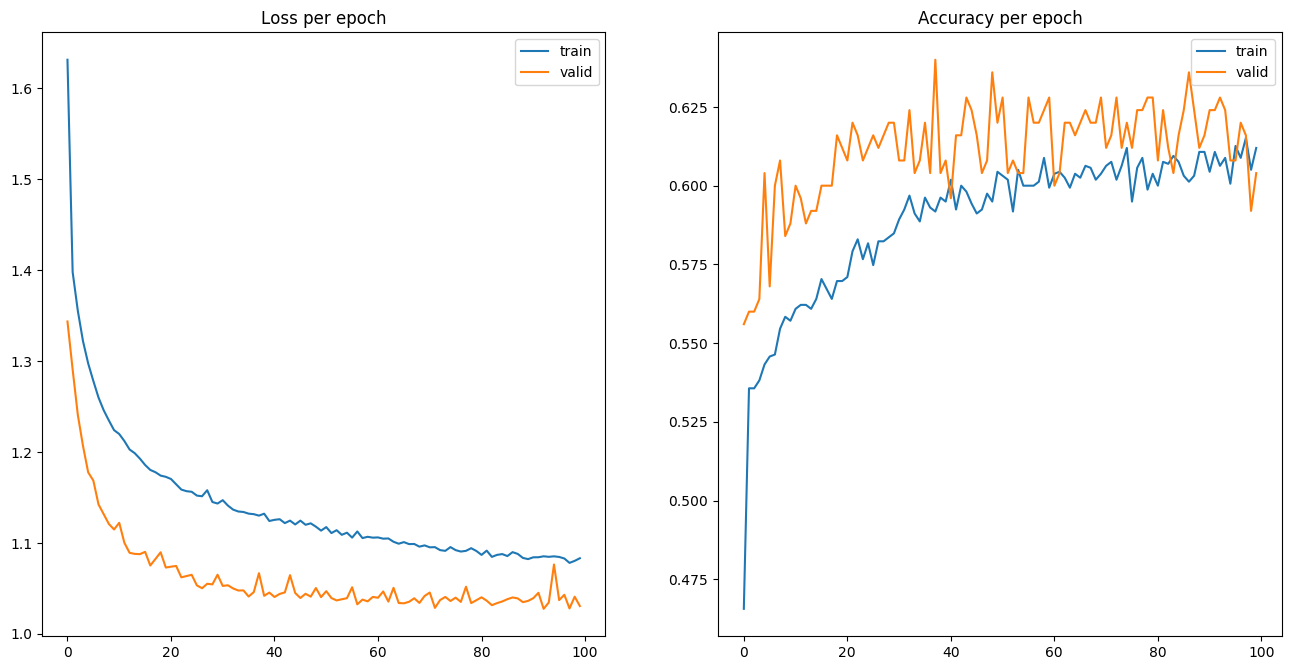

In [111]:
clf.train_and_plot({'train':(bom_train,y_train),'test':(bom_val,y_val)},num_epochs=5000)

Train Loss 1.03125008442
Val Loss 1.0195
Train Acc 0.629022088901
Val Acc 0.632


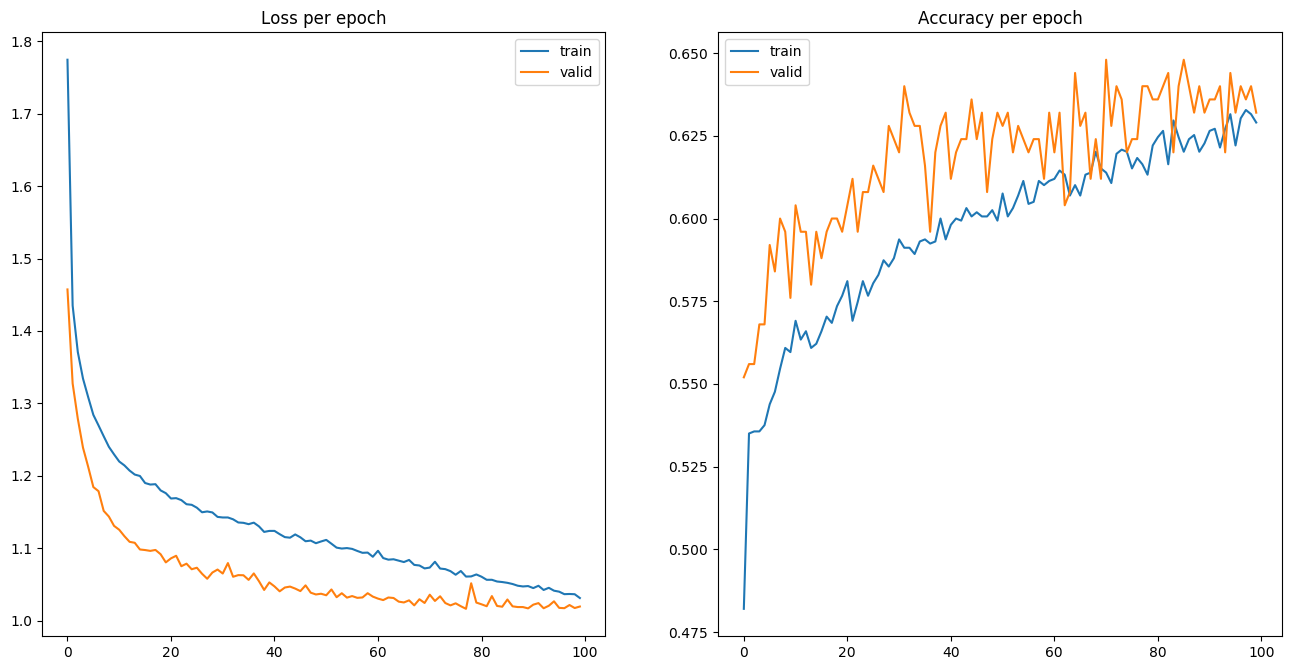

In [112]:
clf2 = TextClassifier(embed_dim=50,hid_dims=[250],num_classes=8,nonlin=tf.nn.relu)
clf2.build_graph()
clf2.train_and_plot({'train':(bom_train,y_train),'test':(bom_val,y_val)},num_epochs=5000)

Train Loss 1.15161080014
Val Loss 1.05698
Train Acc 0.585488959348
Val Acc 0.6


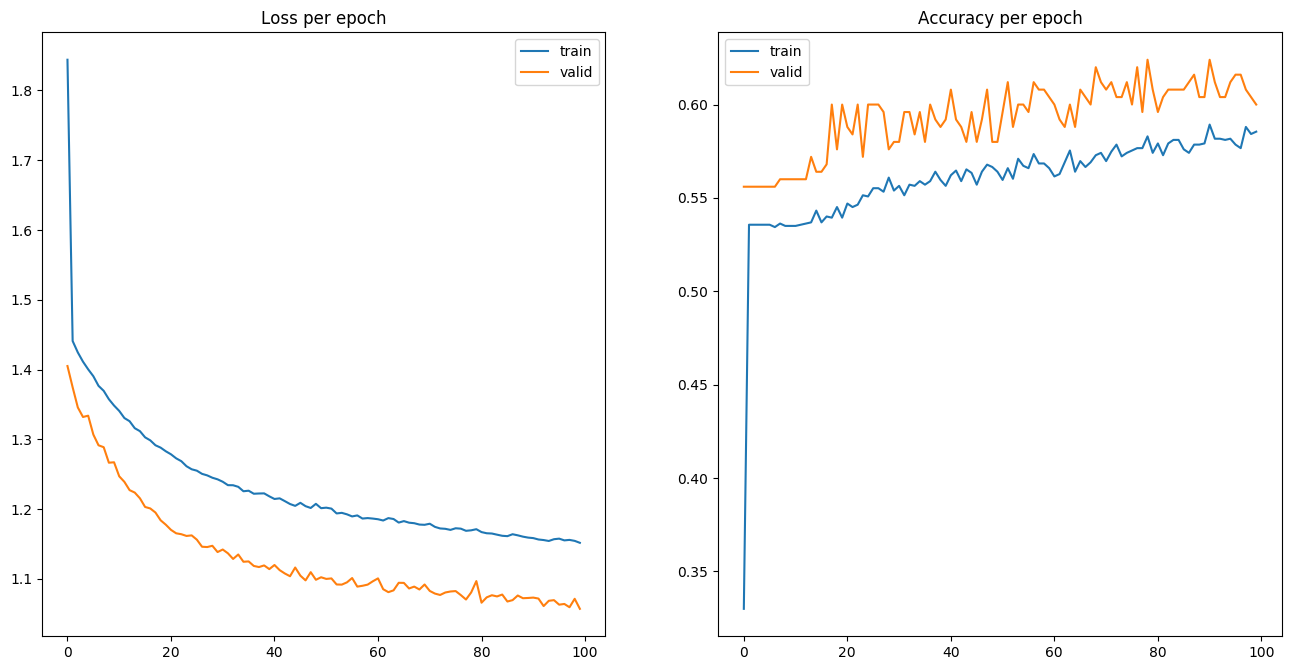

In [113]:
clf3 = TextClassifier(embed_dim=50,hid_dims=[250],num_classes=8,nonlin=tf.sigmoid)
clf3.build_graph()
clf3.train_and_plot({'train':(bom_train,y_train),'test':(bom_val,y_val)},num_epochs=5000)

Train Loss 1.11396230809
Val Loss 1.05245
Train Acc 0.601261828412
Val Acc 0.612


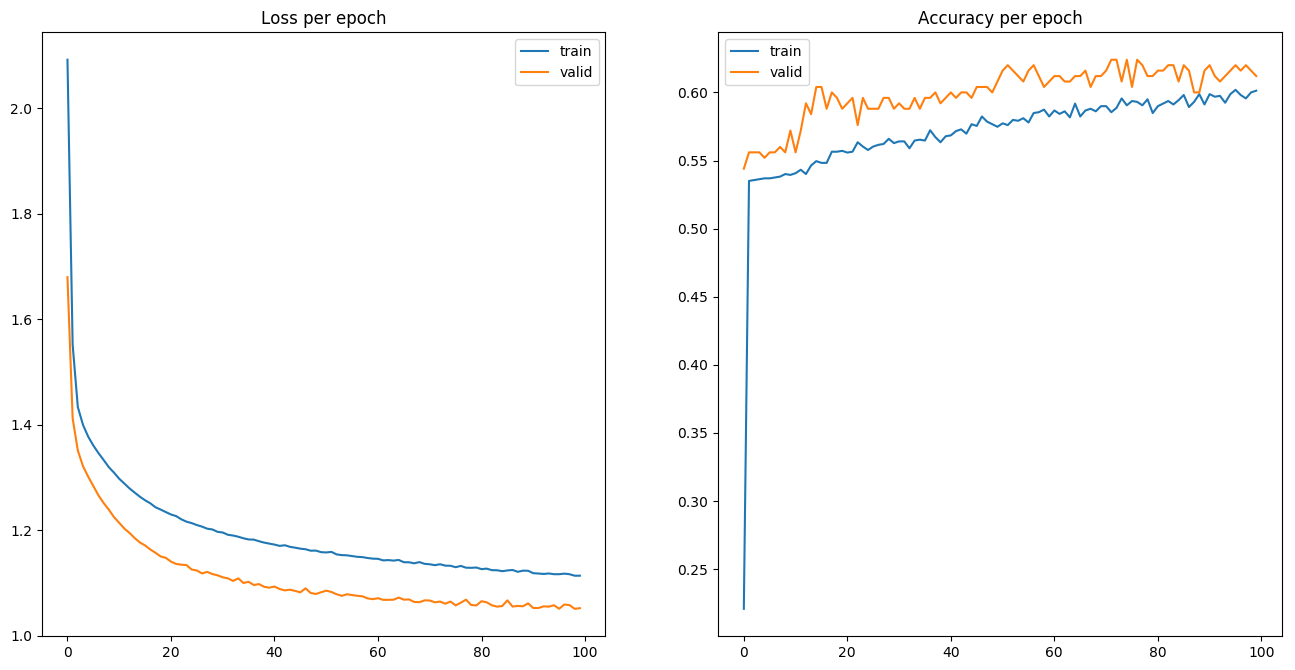

In [114]:
clf4 = TextClassifier(embed_dim=50,hid_dims=[50],num_classes=8,nonlin=tf.tanh)
clf4.build_graph()
clf4.train_and_plot({'train':(bom_train,y_train),'test':(bom_val,y_val)},num_epochs=5000)

Train Loss 1.10054824593
Val Loss 1.03634
Train Acc 0.612618304578
Val Acc 0.608


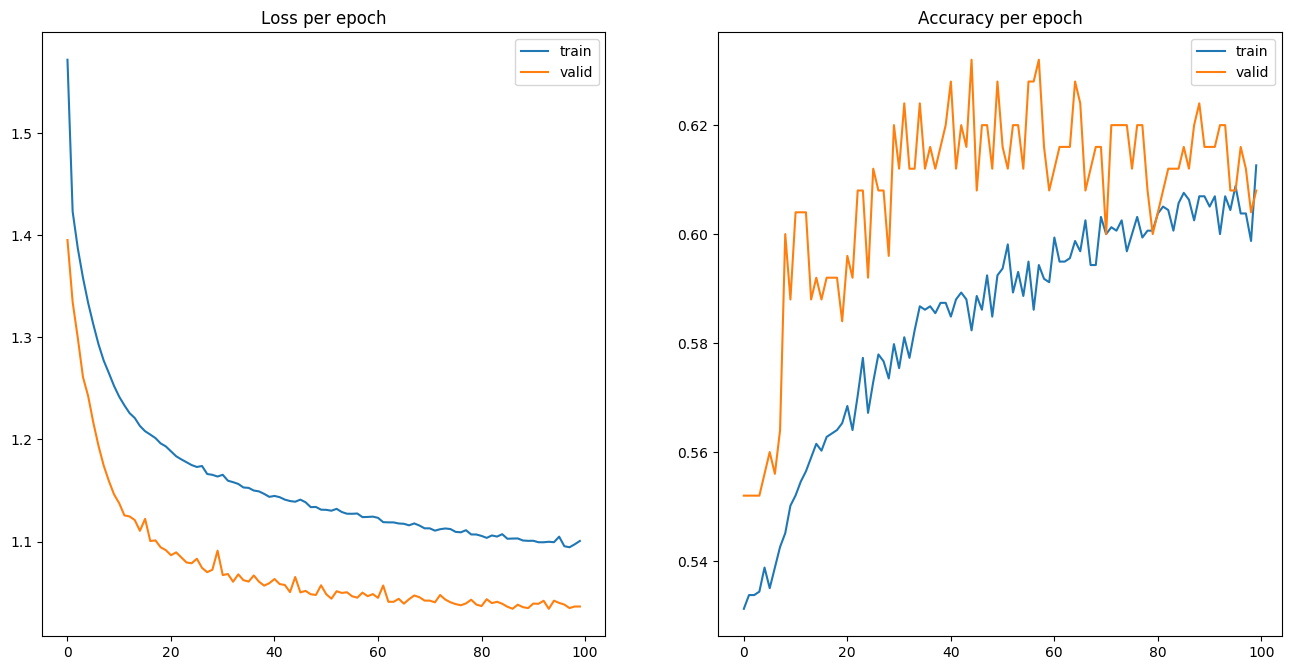

In [115]:
clf5 = TextClassifier(embed_dim=50,hid_dims=[100],num_classes=8,nonlin=tf.tanh)
clf5.build_graph()
clf5.train_and_plot({'train':(bom_train,y_train),'test':(bom_val,y_val)},num_epochs=5000)

Train Loss 1.07590532115
Val Loss 1.05976
Train Acc 0.613880126352
Val Acc 0.628


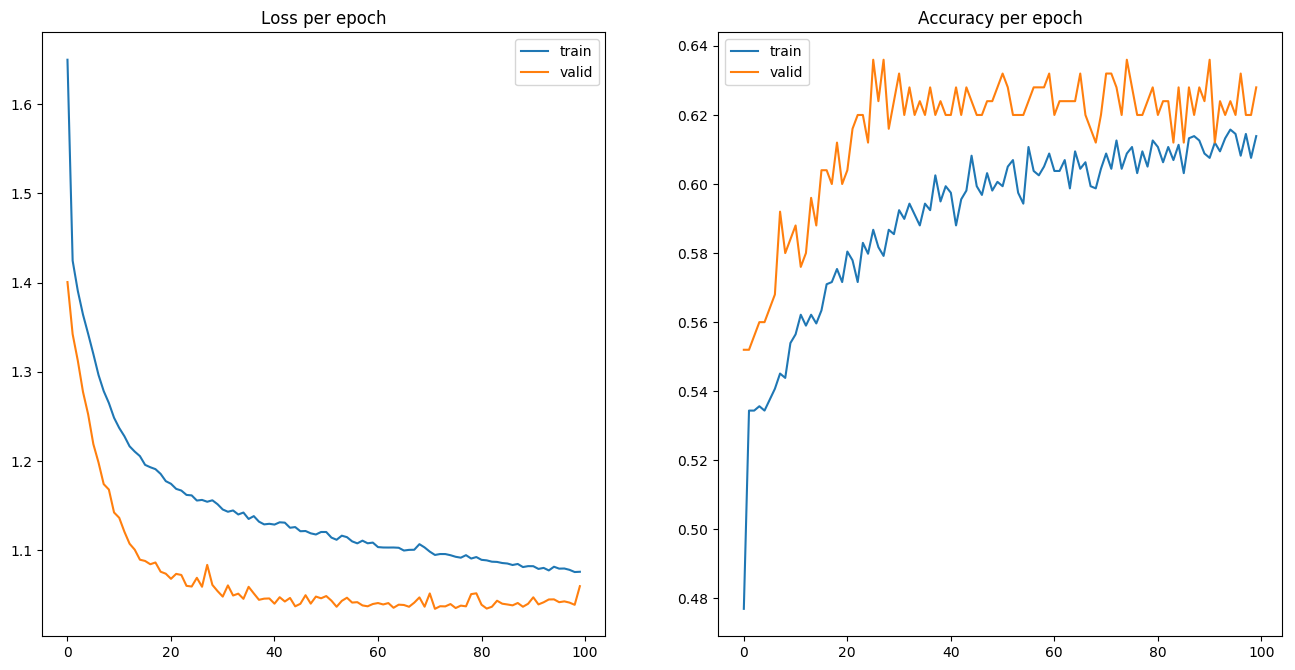

In [116]:
clf6 = TextClassifier(embed_dim=50,hid_dims=[50,50],num_classes=8,nonlin=tf.tanh)
clf6.build_graph()
clf6.train_and_plot({'train':(bom_train,y_train),'test':(bom_val,y_val)},num_epochs=5000)

Train Loss 1.20800576225
Val Loss 1.10939
Train Acc 0.558359628596
Val Acc 0.604


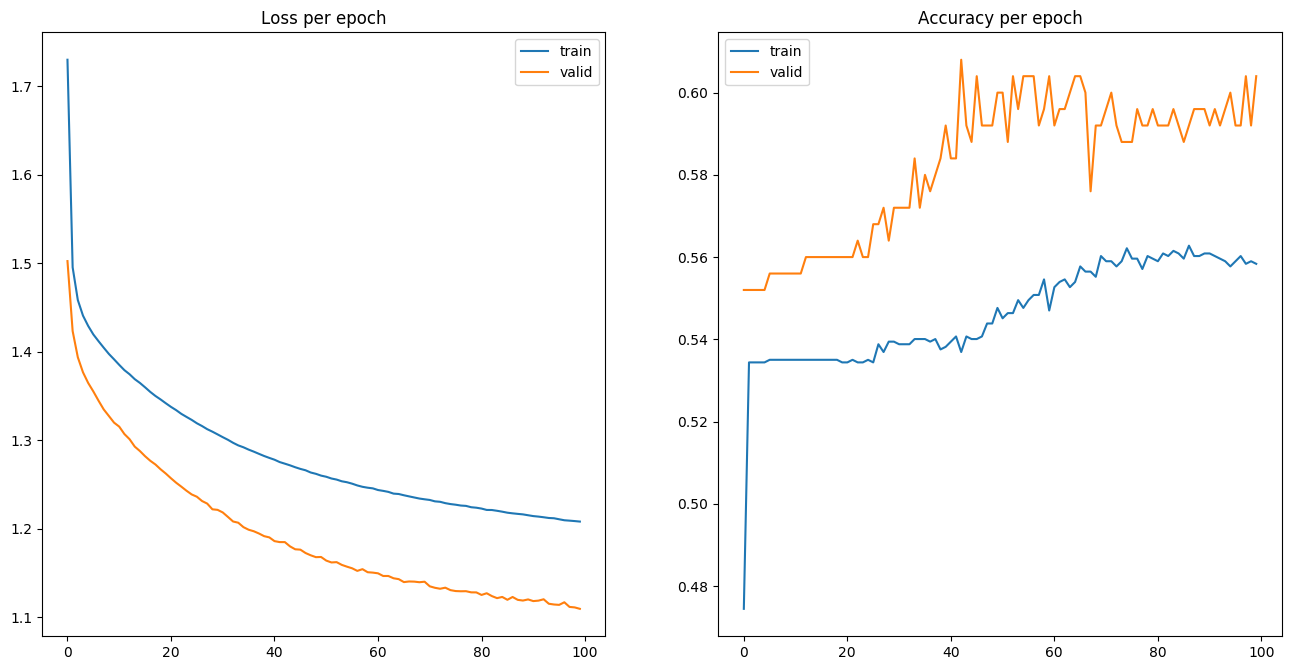

In [117]:
clf7 = TextClassifier(embed_dim=50,hid_dims=[250],
                      num_classes=8,nonlin=tf.tanh,
                     optimizer=tf.train.GradientDescentOptimizer(1e-2))
clf7.build_graph()
clf7.train_and_plot({'train':(bom_train,y_train),'test':(bom_val,y_val)},num_epochs=5000)

In [118]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [119]:
from sklearn.manifold import TSNE
label_words = list(set([t for tag in tags for t in tag.split(', ')]))
tags_vecs = get_embeddings(label_words)


tsne = TSNE(n_components=2, random_state=0)
tags_2d = tsne.fit_transform(tags_vecs)

In [120]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=tags_2d[:,0],
                                    x2=tags_2d[:,1],
                                    names=label_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)